In [79]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
stack_fixed = 'MD593'

In [4]:
train_sample_scheme = 1
global_transform_scheme = 1

local_transform_scheme = 2

reg_weights = np.array([0.,0.,0.])
    
# stack_moving = 'atlas_on_MD589'
stack_moving = 'atlasV2'

In [5]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

structures_sided = sum([[n] if n in singular_structures 
                        else [convert_to_left_name(n), convert_to_right_name(n)] 
                        for n in structures], [])

structures_sided_plus_surround = sum([[s, s+'_surround'] for s in structures_sided], [])

In [6]:
label_to_name_fixed = {i+1: name for i, name in enumerate(sorted(structures))}
name_to_label_fixed = {n:l for l, n in label_to_name_fixed.iteritems()}

In [42]:
# if local_transform_scheme == 1 or local_transform_scheme == 2:
    
# label_to_name_moving = {i+1: name for i, name in enumerate(structures_sided)}
# name_to_label_moving = {n:l for l, n in label_to_name_moving.iteritems()}

# elif local_transform_scheme == 3 or local_transform_scheme == 4:

label_to_name_moving = {i+1: name for i, name in enumerate(structures_sided_plus_surround)}
name_to_label_moving = {n:l for l, n in label_to_name_moving.iteritems()}

Setting environment for Gordon


In [8]:
# Load fixed volumes

volume_fixed = {name_to_label_fixed[name]: DataManager.load_score_volume(stack=stack_fixed, label=name, downscale=32, train_sample_scheme=train_sample_scheme)
               for name in structures}

print volume_fixed.values()[0].shape
print volume_fixed.values()[0].dtype

vol_fixed_ydim, vol_fixed_xdim, vol_fixed_zdim = volume_fixed.values()[0].shape

# vol_fixed_xmin, vol_fixed_ymin, vol_fixed_zmin = (0,0,0)
# vol_fixed_ymax, vol_fixed_xmax, vol_fixed_zmax = np.array(volume_fixed.values()[0].shape) - 1
# vol_fixed_xdim = vol_fixed_xmax + 1 - vol_fixed_xmin
# vol_fixed_ydim = vol_fixed_ymax + 1 - vol_fixed_ymin
# vol_fixed_zdim = vol_fixed_zmax + 1 - vol_fixed_zmin

(383, 534, 374)
float16


In [46]:
# Load moving volumes

# if local_transform_scheme == 3 or local_transform_scheme == 4:

volume_moving = {name_to_label_moving[name_s]: DataManager.load_transformed_volume(stack_m=stack_moving,
                                                                                   type_m='score',
                                                                                   stack_f=stack_fixed,
                                                                                   type_f='score',
                                                                                   downscale=32,
                                                                                   train_sample_scheme_f=train_sample_scheme,
                                                                                   global_transform_scheme=global_transform_scheme,
                                                                                   label=name_s,
                                                                                  local_transform_scheme=2,
                                                                                  transitive='over')
                 for name_s in structures_sided_plus_surround}

# else:

# volume_moving = {name_to_label_moving[name_s]: \
#                  DataManager.load_transformed_volume(stack_m=stack_moving,
#                                                    type_m='score',
#                                                    stack_f=stack_fixed,
#                                                    type_f='score',
#                                                    downscale=32,
#                                                    train_sample_scheme_f=train_sample_scheme,
#                                                    global_transform_scheme=global_transform_scheme,
#                                                    local_transform_scheme=2,
#                                                    label=name_s,
#                                                   transitive='over')
#                  for name_s in structures_sided}    
    
print volume_moving.values()[0].shape
print volume_moving.values()[0].dtype

# vol_moving_xmin, vol_moving_ymin, vol_moving_zmin = (0,0,0)
# vol_moving_ymax, vol_moving_xmax, vol_moving_zmax = np.array(volume_moving.values()[0].shape) - 1

Setting environment for Gordon
(383, 534, 374)
float16


In [47]:
# Load moving volumes

# if local_transform_scheme == 3 or local_transform_scheme == 4:

#     volume_moving = {name_to_label_moving[name_s]: DataManager.load_transformed_volume(stack_m=stack_moving,
#                                                                                        type_m='score',
#                                                                                        stack_f=stack_fixed,
#                                                                                        type_f='score',
#                                                                                        downscale=32,
#                                                                                        train_sample_scheme_f=train_sample_scheme,
#                                                                                        global_transform_scheme=global_transform_scheme,
#                                                                                        label=name_s)
#                      for name_s in structures_sided_plus_surround}

# else:

volume_moving_gtf = {name_to_label_moving[name_s]: \
                 DataManager.load_transformed_volume(stack_m=stack_moving,
                                                   type_m='score',
                                                   stack_f=stack_fixed,
                                                   type_f='score',
                                                   downscale=32,
                                                   train_sample_scheme_f=train_sample_scheme,
                                                   global_transform_scheme=global_transform_scheme,
                                                   label=name_s,
                                                  transitive='to')
                     for name_s in structures_sided_plus_surround}
#                  for name_s in structures_sided}    
                    

print volume_moving_gtf.values()[0].shape
print volume_moving_gtf.values()[0].dtype

# vol_moving_xmin, vol_moving_ymin, vol_moving_zmin = (0,0,0)
# vol_moving_ymax, vol_moving_xmax, vol_moving_zmax = np.array(volume_moving.values()[0].shape) - 1

(383, 534, 374)
float16


In [49]:
labelIndexMap_m2f = {}
for label_m, name_m in label_to_name_moving.iteritems():
    labelIndexMap_m2f[label_m] = name_to_label_fixed[convert_to_original_name(name_m)]
    
label_weights_m = {}
for label_m, name_m in label_to_name_moving.iteritems():
    if 'surround' in name_m:
#         if local_transform_scheme == 3 or local_transform_scheme == 4:
        label_weights_m[label_m] = -1
#         else:
#             label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1

In [26]:
# volume_fixed_sliced = {l: v[..., [160]] for l, v in volume_fixed.iteritems()}
# volume_moving_sliced = {l: v[..., [160]] for l, v in volume_moving.iteritems()}

# Transform

In [50]:
transformed_structure_slices = {}

7N_L
set([7])


load gradient 7: 1.415917 seconds
overall: 1.416066 seconds
iteration 0
step: 0.01 seconds
score: 0.000673
iteration 1
step: 0.00 seconds
score: 0.000586
iteration 2
step: 0.00 seconds
score: 0.000697
iteration 3
step: 0.00 seconds
score: 0.000740
iteration 4
step: 0.00 seconds
score: 0.000814
iteration 5
step: 0.00 seconds
score: 0.000780
iteration 6
step: 0.00 seconds
score: 0.000782
iteration 7
step: 0.00 seconds
score: 0.000738
iteration 8
step: 0.00 seconds
score: 0.000802
iteration 9
step: 0.00 seconds
score: 0.000830
iteration 10
step: 0.00 seconds
score: 0.000837
iteration 11
step: 0.00 seconds
score: 0.000815
iteration 12
step: 0.00 seconds
score: 0.000851
iteration 13
step: 0.00 seconds
score: 0.000841
iteration 14
step: 0.00 seconds
score: 0.000856
iteration 15
step: 0.00 seconds
score: 0.000858
iteration 16
step: 0.00 seconds
score: 0.000873
iteration 17
step: 0.00 seconds
score: 0.000861
iteration 18
step: 0.00 seconds
score: 0.000865
iteration 19
step: 0.00 seconds
score:

[[ 0.97456754  0.44764587  0.          5.34054518]
 [-0.19827785  0.94266706  0.         -0.5098408 ]
 [ 0.          0.          1.          0.        ]]
0.000896276877029 0.000887678441359
7N_L


step: 0.00 seconds
score: 0.000893
iteration 79
step: 0.00 seconds
score: 0.000892
iteration 80
step: 0.00 seconds
score: 0.000888
iteration 81
step: 0.00 seconds
score: 0.000891
iteration 82
step: 0.00 seconds
score: 0.000889
iteration 83
step: 0.00 seconds
score: 0.000892
iteration 84
step: 0.00 seconds
score: 0.000889
iteration 85
step: 0.00 seconds
score: 0.000889
iteration 86
step: 0.00 seconds
score: 0.000889
iteration 87
step: 0.00 seconds
score: 0.000891
iteration 88
step: 0.00 seconds
score: 0.000889
iteration 89
step: 0.00 seconds
score: 0.000890
iteration 90
step: 0.00 seconds
score: 0.000891
iteration 91
step: 0.00 seconds
score: 0.000893
iteration 92
step: 0.00 seconds
score: 0.000893
iteration 93
step: 0.00 seconds
score: 0.000893
iteration 94
step: 0.00 seconds
score: 0.000892
iteration 95
step: 0.00 seconds
score: 0.000888
iteration 96
step: 0.00 seconds
score: 0.000889
iteration 97
step: 0.00 seconds
score: 0.000891
iteration 98
step: 0.00 seconds
score: 0.000887
itera

set([7])


load gradient 7: 0.504695 seconds
overall: 0.504824 seconds
iteration 0
step: 0.00 seconds
score: 0.000645
iteration 1
step: 0.00 seconds
score: 0.000701
iteration 2
step: 0.00 seconds
score: 0.000623
iteration 3
step: 0.00 seconds
score: 0.000697
iteration 4
step: 0.00 seconds
score: 0.000768
iteration 5
step: 0.00 seconds
score: 0.000750
iteration 6
step: 0.00 seconds
score: 0.000745
iteration 7
step: 0.00 seconds
score: 0.000777
iteration 8
step: 0.00 seconds
score: 0.000789
iteration 9
step: 0.00 seconds
score: 0.000814
iteration 10
step: 0.00 seconds
score: 0.000814
iteration 11
step: 0.00 seconds
score: 0.000821
iteration 12
step: 0.00 seconds
score: 0.000819
iteration 13
step: 0.00 seconds
score: 0.000817
iteration 14
step: 0.00 seconds
score: 0.000821
iteration 15
step: 0.00 seconds
score: 0.000817
iteration 16
step: 0.00 seconds
score: 0.000824
iteration 17
step: 0.00 seconds
score: 0.000820
iteration 18
step: 0.00 seconds
score: 0.000827
iteration 19
step: 0.00 seconds
score:

[[ 0.9874593   0.37423095  0.          5.76958206]
 [-0.21616592  0.914451    0.         -0.03431074]
 [ 0.          0.          1.          0.        ]]
0.000836101651657 0.000832097342936
7N_L


step: 0.00 seconds
score: 0.000825
iteration 83
step: 0.00 seconds
score: 0.000831
iteration 84
step: 0.00 seconds
score: 0.000830
iteration 85
step: 0.00 seconds
score: 0.000829
iteration 86
step: 0.00 seconds
score: 0.000825
iteration 87
step: 0.00 seconds
score: 0.000830
iteration 88
step: 0.00 seconds
score: 0.000827
iteration 89
step: 0.00 seconds
score: 0.000832
iteration 90
step: 0.00 seconds
score: 0.000828
iteration 91
step: 0.00 seconds
score: 0.000834
iteration 92
step: 0.00 seconds
score: 0.000824
iteration 93
step: 0.00 seconds
score: 0.000832
iteration 94
step: 0.00 seconds
score: 0.000831
iteration 95
step: 0.00 seconds
score: 0.000835
iteration 96
step: 0.00 seconds
score: 0.000828
iteration 97
step: 0.00 seconds
score: 0.000833
iteration 98
step: 0.00 seconds
score: 0.000833
iteration 99
step: 0.00 seconds
score: 0.000832
iteration 100
step: 0.00 seconds
score: 0.000834
iteration 101
step: 0.00 seconds
score: 0.000827
iteration 102
step: 0.00 seconds
score: 0.000834
it

set([7])


load gradient 7: 0.503993 seconds
overall: 0.504097 seconds
iteration 0
step: 0.00 seconds
score: 0.000776
iteration 1
step: 0.00 seconds
score: 0.000700
iteration 2
step: 0.00 seconds
score: 0.000800
iteration 3
step: 0.00 seconds
score: 0.000912
iteration 4
step: 0.00 seconds
score: 0.000964
iteration 5
step: 0.00 seconds
score: 0.000969
iteration 6
step: 0.00 seconds
score: 0.000956
iteration 7
step: 0.00 seconds
score: 0.000950
iteration 8
step: 0.00 seconds
score: 0.000990
iteration 9
step: 0.00 seconds
score: 0.000970
iteration 10
step: 0.00 seconds
score: 0.000992
iteration 11
step: 0.00 seconds
score: 0.000983
iteration 12
step: 0.00 seconds
score: 0.000993
iteration 13
step: 0.00 seconds
score: 0.000976
iteration 14
step: 0.00 seconds
score: 0.000945
iteration 15
step: 0.00 seconds
score: 0.000941
iteration 16
step: 0.00 seconds
score: 0.000954
iteration 17
step: 0.00 seconds
score: 0.000968
iteration 18
step: 0.00 seconds
score: 0.000984
iteration 19
step: 0.00 seconds
score:

[[ 1.02613335  0.2509881   0.          5.91324976]
 [-0.10238247  1.0065002   0.         -1.00980109]
 [ 0.          0.          1.          0.        ]]
0.00100867325091 0.00100566912442
7N_L


step: 0.00 seconds
score: 0.000999
iteration 82
step: 0.00 seconds
score: 0.000997
iteration 83
step: 0.00 seconds
score: 0.001004
iteration 84
step: 0.00 seconds
score: 0.001000
iteration 85
step: 0.00 seconds
score: 0.001003
iteration 86
step: 0.00 seconds
score: 0.000996
iteration 87
step: 0.00 seconds
score: 0.000998
iteration 88
step: 0.00 seconds
score: 0.000992
iteration 89
step: 0.00 seconds
score: 0.001002
iteration 90
step: 0.00 seconds
score: 0.000997
iteration 91
step: 0.00 seconds
score: 0.001000
iteration 92
step: 0.00 seconds
score: 0.001000
iteration 93
step: 0.00 seconds
score: 0.001001
iteration 94
step: 0.00 seconds
score: 0.001006
iteration 95
step: 0.00 seconds
score: 0.001002
iteration 96
step: 0.00 seconds
score: 0.001005
iteration 97
step: 0.00 seconds
score: 0.001007
iteration 98
step: 0.00 seconds
score: 0.001001
iteration 99
step: 0.00 seconds
score: 0.001000
iteration 100
step: 0.00 seconds
score: 0.001001
iteration 101
step: 0.00 seconds
score: 0.001005
ite

set([7])


load gradient 7: 0.499804 seconds
overall: 0.499954 seconds
iteration 0
step: 0.00 seconds
score: 0.000732
iteration 1
step: 0.00 seconds
score: 0.000428
iteration 2
step: 0.00 seconds
score: 0.000898
iteration 3
step: 0.00 seconds
score: 0.000900
iteration 4
step: 0.00 seconds
score: 0.000960
iteration 5
step: 0.00 seconds
score: 0.000925
iteration 6
step: 0.00 seconds
score: 0.001010
iteration 7
step: 0.00 seconds
score: 0.000988
iteration 8
step: 0.00 seconds
score: 0.000996
iteration 9
step: 0.00 seconds
score: 0.000976
iteration 10
step: 0.00 seconds
score: 0.000997
iteration 11
step: 0.00 seconds
score: 0.000996
iteration 12
step: 0.00 seconds
score: 0.001005
iteration 13
step: 0.00 seconds
score: 0.001005
iteration 14
step: 0.00 seconds
score: 0.001006
iteration 15
step: 0.00 seconds
score: 0.001013
iteration 16
step: 0.00 seconds
score: 0.001014
iteration 17
step: 0.00 seconds
score: 0.001013
iteration 18
step: 0.00 seconds
score: 0.001012
iteration 19
step: 0.00 seconds
score:

[[ 0.99109784  0.61672672  0.          6.51750439]
 [-0.21926527  0.84516683  0.         -1.58176126]
 [ 0.          0.          1.          0.        ]]
0.00103020551614 0.00102646896266
7N_L


step: 0.00 seconds
score: 0.001020
iteration 81
step: 0.00 seconds
score: 0.001021
iteration 82
step: 0.00 seconds
score: 0.001022
iteration 83
step: 0.00 seconds
score: 0.001020
iteration 84
step: 0.00 seconds
score: 0.001019
iteration 85
step: 0.00 seconds
score: 0.001015
iteration 86
step: 0.00 seconds
score: 0.001017
iteration 87
step: 0.00 seconds
score: 0.001018
iteration 88
step: 0.00 seconds
score: 0.001021
iteration 89
step: 0.00 seconds
score: 0.001021
iteration 90
step: 0.00 seconds
score: 0.001023
iteration 91
step: 0.00 seconds
score: 0.001021
iteration 92
step: 0.00 seconds
score: 0.001021
iteration 93
step: 0.00 seconds
score: 0.001024
iteration 94
step: 0.00 seconds
score: 0.001021
iteration 95
step: 0.00 seconds
score: 0.001020
iteration 96
step: 0.00 seconds
score: 0.001022
iteration 97
step: 0.00 seconds
score: 0.001024
iteration 98
step: 0.00 seconds
score: 0.001021
iteration 99
step: 0.00 seconds
score: 0.001023
iteration 100
step: 0.00 seconds
score: 0.001026
iter

set([7])


load gradient 7: 0.486108 seconds
overall: 0.486234 seconds
iteration 0
step: 0.00 seconds
score: 0.000881
iteration 1
step: 0.00 seconds
score: 0.000702
iteration 2
step: 0.00 seconds
score: 0.000695
iteration 3
step: 0.00 seconds
score: 0.000872
iteration 4
step: 0.00 seconds
score: 0.000945
iteration 5
step: 0.00 seconds
score: 0.000974
iteration 6
step: 0.00 seconds
score: 0.000987
iteration 7
step: 0.00 seconds
score: 0.000993
iteration 8
step: 0.00 seconds
score: 0.000980
iteration 9
step: 0.00 seconds
score: 0.000997
iteration 10
step: 0.00 seconds
score: 0.000997
iteration 11
step: 0.00 seconds
score: 0.000998
iteration 12
step: 0.00 seconds
score: 0.000983
iteration 13
step: 0.00 seconds
score: 0.000964
iteration 14
step: 0.00 seconds
score: 0.000953
iteration 15
step: 0.00 seconds
score: 0.000974
iteration 16
step: 0.00 seconds
score: 0.000956
iteration 17
step: 0.00 seconds
score: 0.000983
iteration 18
step: 0.00 seconds
score: 0.000981
iteration 19
step: 0.00 seconds
score:

[[ 1.01721007  0.38047911  0.          3.56780001]
 [-0.11307421  0.87687456  0.          0.66812788]
 [ 0.          0.          1.          0.        ]]
0.00101755317883 0.00100532791112
7N_L


step: 0.00 seconds
score: 0.001000
iteration 81
step: 0.00 seconds
score: 0.001009
iteration 82
step: 0.00 seconds
score: 0.001007
iteration 83
step: 0.00 seconds
score: 0.001010
iteration 84
step: 0.00 seconds
score: 0.001006
iteration 85
step: 0.00 seconds
score: 0.001005
iteration 86
step: 0.00 seconds
score: 0.001003
iteration 87
step: 0.00 seconds
score: 0.001007
iteration 88
step: 0.00 seconds
score: 0.001010
iteration 89
step: 0.00 seconds
score: 0.001010
iteration 90
step: 0.00 seconds
score: 0.001014
iteration 91
step: 0.00 seconds
score: 0.001013
iteration 92
step: 0.00 seconds
score: 0.001004
iteration 93
step: 0.00 seconds
score: 0.001008
iteration 94
step: 0.00 seconds
score: 0.001008
iteration 95
step: 0.00 seconds
score: 0.001000
iteration 96
step: 0.00 seconds
score: 0.000999
iteration 97
step: 0.00 seconds
score: 0.001014
iteration 98
step: 0.00 seconds
score: 0.001003
iteration 99
step: 0.00 seconds
score: 0.001009
iteration 100
step: 0.00 seconds
score: 0.001011
iter

set([7])


load gradient 7: 0.477907 seconds
overall: 0.478031 seconds
iteration 0
step: 0.00 seconds
score: 0.000687
iteration 1
step: 0.00 seconds
score: 0.000564
iteration 2
step: 0.00 seconds
score: 0.000698
iteration 3
step: 0.00 seconds
score: 0.000819
iteration 4
step: 0.00 seconds
score: 0.000825
iteration 5
step: 0.00 seconds
score: 0.000832
iteration 6
step: 0.00 seconds
score: 0.000850
iteration 7
step: 0.00 seconds
score: 0.000866
iteration 8
step: 0.00 seconds
score: 0.000881
iteration 9
step: 0.00 seconds
score: 0.000867
iteration 10
step: 0.00 seconds
score: 0.000867
iteration 11
step: 0.00 seconds
score: 0.000867
iteration 12
step: 0.00 seconds
score: 0.000877
iteration 13
step: 0.00 seconds
score: 0.000875
iteration 14
step: 0.00 seconds
score: 0.000876
iteration 15
step: 0.00 seconds
score: 0.000880
iteration 16
step: 0.00 seconds
score: 0.000883
iteration 17
step: 0.00 seconds
score: 0.000889
iteration 18
step: 0.00 seconds
score: 0.000885
iteration 19
step: 0.00 seconds
score:

[[ 1.00422934  0.24616288  0.          5.53652896]
 [-0.09439367  0.93953968  0.         -0.73891246]
 [ 0.          0.          1.          0.        ]]
0.000902686384507 0.000901006627828


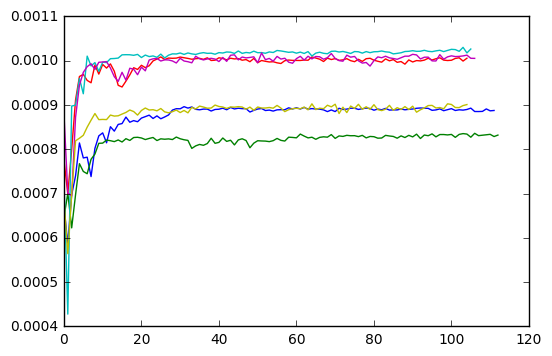

In [73]:
first_sec, last_sec = metadata_cache['section_limits'][stack_fixed]
bar = show_progress_bar(first_sec, last_sec)

for sec in range(first_sec, last_sec+1):
# for sec in range(143, 149):
    
    bar.value = sec
    
    zl, zh = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
    z = int(np.round((zl + zh)/2))
    
    # align with z=z
    
    # for name_s in structures_sided:
    for name_s in ['7N_L']:

        print name_s

#         if local_transform_scheme == 1 or local_transform_scheme == 2:
    
#             aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
#                                               volume_moving[name_to_label_moving[name_s]]}, \
#                                labelIndexMap_m2f={name_to_label_moving[name_s]:
#                                                   name_to_label_fixed[convert_name_to_unsided(name_s)]},
#                               zrange=(z,z))

#         elif local_transform_scheme == 3 or local_transform_scheme == 4:

        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]},
                          zrange=(z,z))
        
        
#         aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
#                                           volume_moving[name_to_label_moving[name_s]]}, \
#                            labelIndexMap_m2f={name_to_label_moving[name_s]:
#                                               name_to_label_fixed[convert_name_to_unsided(name_s)]},
#                           zrange=(z,z))

        # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                             indices_m=[name_to_label_moving[name_s]])

        gradient_filepath_map_f = {ind_f: VOLUME_ROOTDIR + '/%(stack)s/score_volume_gradients/%(stack)s_down32_scoreVolume_%(label)s_trainSampleScheme_%(scheme)d_%%(suffix)s.bp' % \
                               {'stack': stack_fixed, 'label': label_to_name_fixed[ind_f], 'scheme':train_sample_scheme}
                               for ind_m, ind_f in labelIndexMap_m2f.iteritems()}

        aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=None)

        t = time.time()
        T, scores = aligner.optimize(type='affine', max_iter_num=1000, history_len=50, terminate_thresh=1e-5,
                                     indices_m=None,
    #                                 grid_search_iteration_number=20,
    #                                  grid_search_sample_number=1000,
    #                                 std_tx=10, std_ty=10, std_tz=0, std_theta_xy=np.deg2rad(10),
                                     grad_computation_sample_number=1e5,
                                     full_lr=[.1,.1,0,10,.1,.1,0,10,0,0,0,0],
                                    label_weights=label_weights_m,
                                    reg_weights=reg_weights,
                                    epsilon=1e-8)

    #     T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=100, terminate_thresh=1e-6,
    #                                      indices_m=None,
    #                                     grid_search_iteration_number=20,
    #                                      grid_search_sample_number=1000,
    #                                     std_tx=5, std_ty=5, std_tz=0, std_theta_xy=np.deg2rad(5),
    #                                      grad_computation_sample_number=1e5,
    #                                      full_lr=[20,20,0,0,0,.1],
    #                                     label_weights=label_weights_m,
    #                                     reg_weights=reg_weights,
    #                                     epsilon=1e-8)

        sys.stderr.write('%.2f seconds\n' % (time.time() - t))

        print T.reshape((3,4))
        plt.plot(scores);
        print max(scores), scores[-1]
    
    local_params, centroid_m, centroid_f, xdim_f, ydim_f = \
    T.reshape((3,4))[:2,[0,1,3]].flatten(), aligner.centroid_m, aligner.centroid_f, \
    aligner.xdim_f, aligner.ydim_f
    
    transformed_structure_slice = transform_slice(volume_moving[name_to_label_moving[name_s]][..., z], 
                    T=local_params, centroid_m=aligner.centroid_m[:2], centroid_f=aligner.centroid_f[:2], 
                    xdim_f=xdim_f, ydim_f=ydim_f)
    
    transformed_structure_slices[sec] = transformed_structure_slice

# Visualize

In [74]:
# Set colors for different contour level
levels = [0.1, 0.25, 0.5, 0.75, .99]
level_colors = {level: (int(level*255),0,0) for level in levels}

In [75]:
name_s = '7N_L'

In [76]:
sec2fn = metadata_cache['sections_to_filenames'][stack_fixed]

In [77]:
SLICE_TF_VIZ_DIR = create_if_not_exists('/home/yuncong/csd395/CSHL_sliceTfViz/%(stack)s/' % dict(stack=stack_fixed))

In [78]:
# For getting correct contour location
xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_volume_bbox(stack=stack_fixed, type='score', label=convert_to_original_name(name_s), downscale=32)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# Generate overlay visualization

# Generate atlas overlay image for every section
# first_sec, last_sec = metadata_cache['section_limits'][stack_fixed]
# bar = show_progress_bar(first_sec, last_sec)

# for sec in range(first_sec, last_sec+1):
# for sec in [146]:
#     zl, zh = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
#     z = int(np.round((zl + zh)/2))

for sec, transformed_structure_slice in transformed_structure_slices.iteritems():
    
    zl, zh = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
    z = int(np.round((zl + zh)/2))
    
# if metadata_cache['sections_to_filenames'][stack_fixed][sec] in ['Placeholder', 'Rescan', 'Nonexisting']:
#     continue

#     sec = DataManager.convert_z_to_section(stack=stack_fixed, z=z, downsample=32)

#     bar.value = sec

    # if z < roi_zmin or z > roi_zmax:
    #     continue

    # img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
    img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='lossless', version='compressed')
    img = imread(img_fn)[::4, ::4]

    viz = img.copy()

    
    gtf_slice = volume_moving_gtf[name_to_label_moving[name_s]][..., z]
    
    for level in levels:
        cnts = find_contours(gtf_slice, level=level) # rows, cols
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:,::-1] + (xmin_vol_f, ymin_vol_f)
    #         cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 2)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)*8], True, (0,0,255), 1)
    
    
    ltf_slice = volume_moving[name_to_label_moving[name_s]][..., z]
    
    for level in levels:
        cnts = find_contours(ltf_slice, level=level) # rows, cols
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:,::-1] + (xmin_vol_f, ymin_vol_f)
    #         cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 2)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)*8], True, (0,255,0), 1)


    # Find moving volume annotation contours
    #     for name_s, vol in vols_m_aligned_to_f.iteritems():
    for level in levels:
        cnts = find_contours(transformed_structure_slice, level=level) # rows, cols
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:,::-1] + (xmin_vol_f, ymin_vol_f)
    #         cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 2)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)*8], True, (255,0,0), 1)

#     display_image(viz)

#     plt.figure(figsize=(20,20));
#     plt.imshow(viz);
#     plt.title('z=%d, sec=%d' % (z, sec));
#     plt.show()

    viz_fn = os.path.join(SLICE_TF_VIZ_DIR, '%(fn)s_sliceTfViz.jpg' % {'fn': sec2fn[sec]})
    imsave(viz_fn, viz)

0 533 0 382 111 484
